### 1. Imports

In [1]:
import os
import pandas as pd
from lcfunctions import download_alerce_lc, download_lasair_lc, display_lightcurve
from lcfunctions import lasair_clean, load_lasair_lc

### 2. Load dataframe of AAVSO CVs in ZTF

In [5]:
# Load dataset
df_ZTF_CVs = pd.read_csv('../processed_data/AAVSOCVsZTFxmatch_21032023_BTS_labelled.csv')
# test = pd.read_csv('../processed_data/AAVSOCVsZTFxmatch_21032023_BTS_manual_labelled.xlsm')

df_ZTF_CVs.CV_Types.value_counts()

dwarf_nova            4822
nova_like              263
polar                  126
nova                    88
intermediate_polar      54
AMCVn                   46
Name: CV_Types, dtype: int64

In [3]:
# List of objects.
lst = df_ZTF_CVs.Xmatch_obj.to_list()
# Check length of objects list
print(f'Length of list of objects: {len(lst)}')

Length of list of objects: 5708


### Display light curves

In [69]:
date = '2023_03_25'

manuallist = True

# Apply errorbars
error = False

if error == True:
        errCollasair1 = 'sigmapsf'
        errCollasair2 = 'dc_sigmag'
else:
    errCollasair1 = None
    errCollasair2 = None

objlist = df_ZTF_CVs[df_ZTF_CVs['Type'].str.contains('UGZ', na=False)]['Xmatch_obj'].iloc[20:40]
objtype = df_ZTF_CVs[df_ZTF_CVs['Type'].str.contains('UGZ', na=False)]['Type'].iloc[20:40]

if manuallist==True:
     objlist = ['ZTF18abajshu','ZTF18aagrgoe','ZTF18abchhxd','ZTF18aabfcyi','ZTF18abnzbxh','ZTF18acrsmyu','ZTF21abhrevv',
                'ZTF18abavrji','ZTF18aanwrti','ZTF18aammncw','ZTF19abzzuin','ZTF18acyerom','ZTF20abgbxco','ZTF18achemir',
                'ZTF18abmaqoi','ZTF18adlkmio','ZTF18abiwtyk','ZTF18aaueblh','ZTF18aakvuwy']

i=0
for object, type in zip(objlist, objtype):
    print(i, object, type)
    
    # Display lasair difference magnitude and apparent magnitude light curves.
    lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_{date}')
    lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)

    # print('Lasair difference magnitude')
    # display_lightcurve(lc_lasair,x='jd',y='magpsf',errorCol=errCollasair1)
    print('Lasair apparent magnitude')
    display_lightcurve(lc_lasair_appmag,x='jd',y='dc_mag',errorCol=errCollasair2)
    i+=1


0 ZTF18abajshu UGZ
Lasair apparent magnitude


1 ZTF18aagrgoe UGZ
Lasair apparent magnitude


2 ZTF18abchhxd UGZ
Lasair apparent magnitude


3 ZTF18aabfcyi UGZ
Lasair apparent magnitude


4 ZTF18abnzbxh UGZ
Lasair apparent magnitude


5 ZTF18acrsmyu UGZ
Lasair apparent magnitude


6 ZTF21abhrevv UGZ
Lasair apparent magnitude


7 ZTF18abavrji UGZ
Lasair apparent magnitude


8 ZTF18aanwrti UGZ
Lasair apparent magnitude


9 ZTF18aammncw UGZ
Lasair apparent magnitude


10 ZTF19abzzuin UGZ
Lasair apparent magnitude


11 ZTF18acyerom UGZ
Lasair apparent magnitude


12 ZTF20abgbxco UGZ
Lasair apparent magnitude


13 ZTF18achemir UGZ
Lasair apparent magnitude


14 ZTF18abmaqoi UGZ
Lasair apparent magnitude


15 ZTF18adlkmio UGZ
Lasair apparent magnitude


16 ZTF18abiwtyk UGZ
Lasair apparent magnitude


17 ZTF18aaueblh UGZ
Lasair apparent magnitude


18 ZTF18aakvuwy UGZ
Lasair apparent magnitude


ZTF18abajshu EA+NL


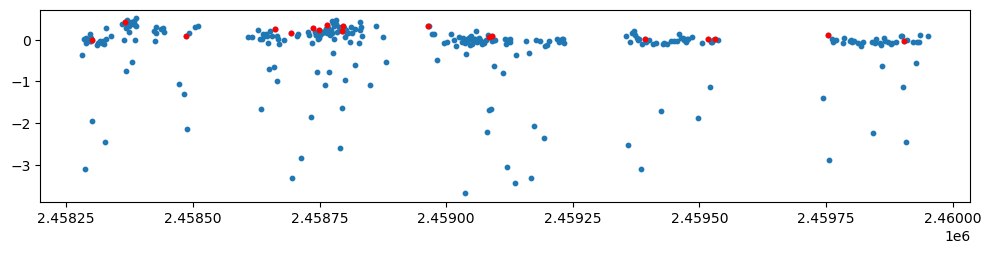

1.9273153682794693
1.8345943775086937


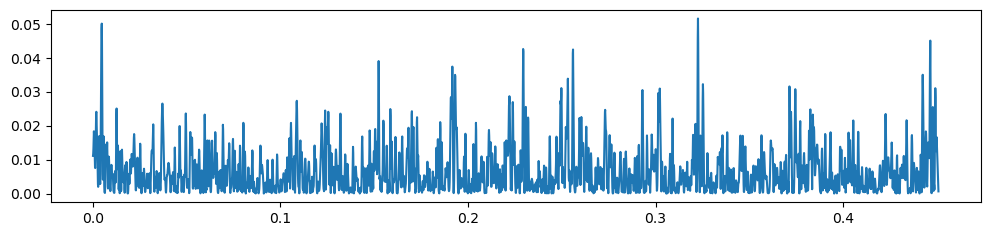

18 0.08486647254231339 -0.00016300175782325377 4.1913772840154735 1.989061946247661
ZTF18aagrgoe NA+NL/VY


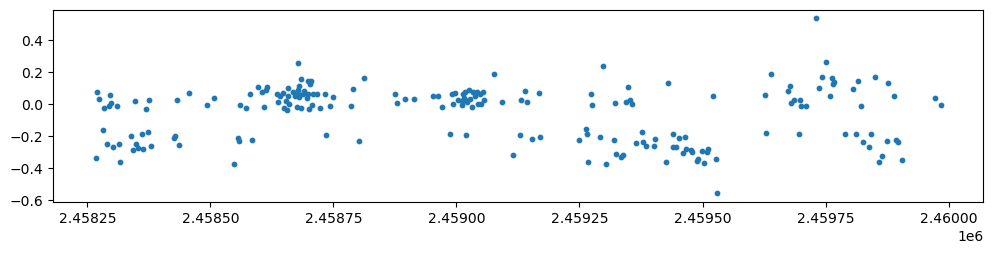

error


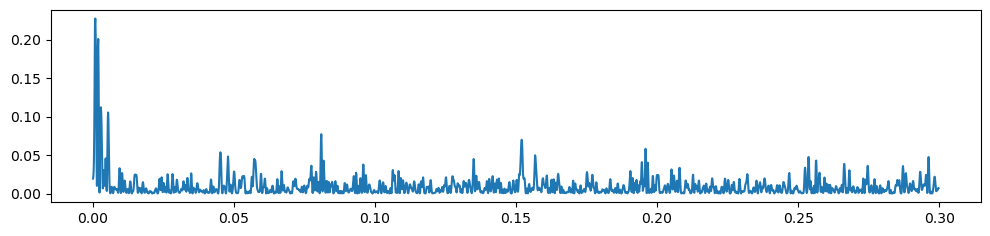

ZTF18abchhxd NA+NL/VY


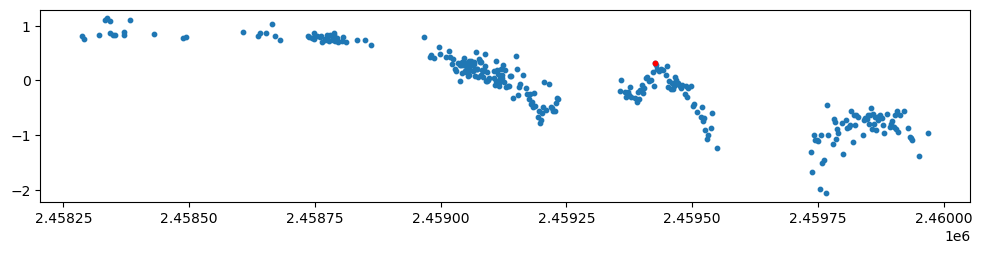

0.004833811841734923
0.003255714446344992


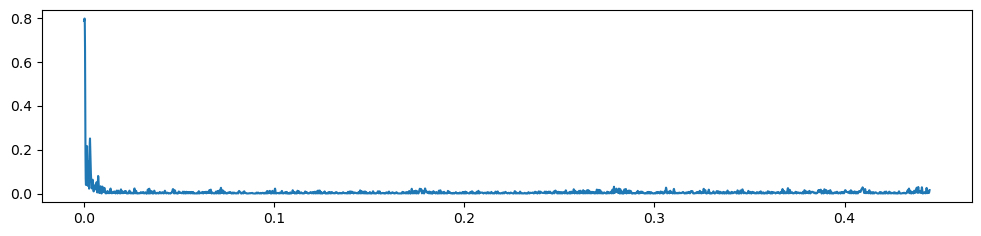

1 5.348065874456639e-101 -0.0013559063360723633 3.1987729428700256 1.1069429117572973
ZTF18aabfcyi UGSU


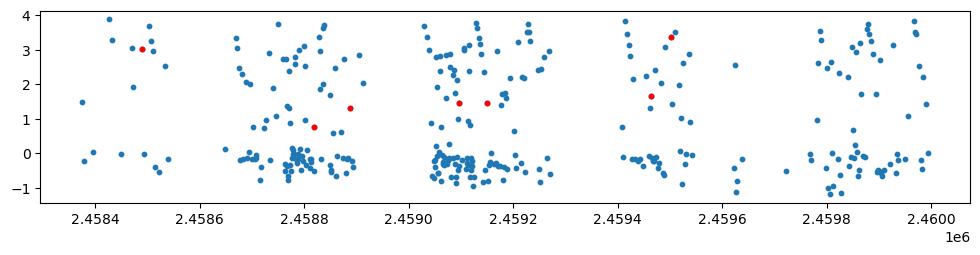

0.8267343334820083
1.2074434986072937


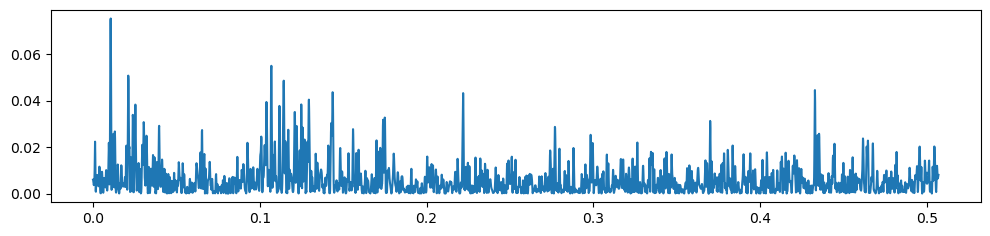

7 0.9887279805152687 2.787971234020396e-06 5.067531314434362 1.9390407769912272
ZTF18abnzbxh UGSU


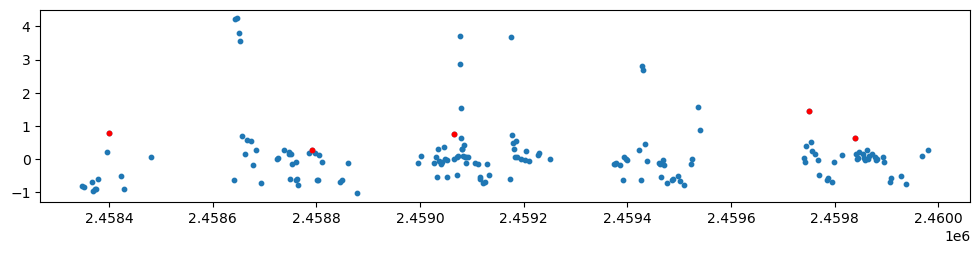

0.17059402829862375
0.2062629287323047


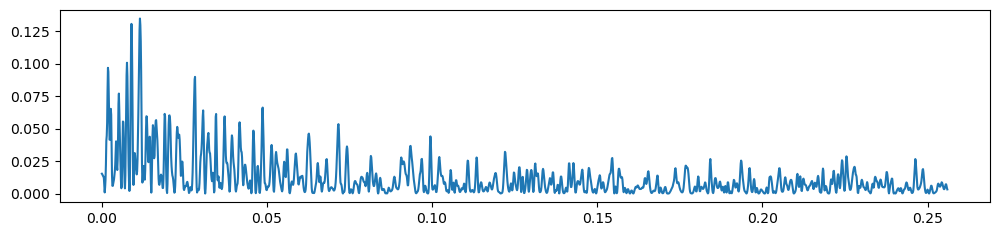

5 0.564803100931981 -9.422314599603801e-05 5.272320476337892 1.6702974732058102
ZTF18acrsmyu UGSU


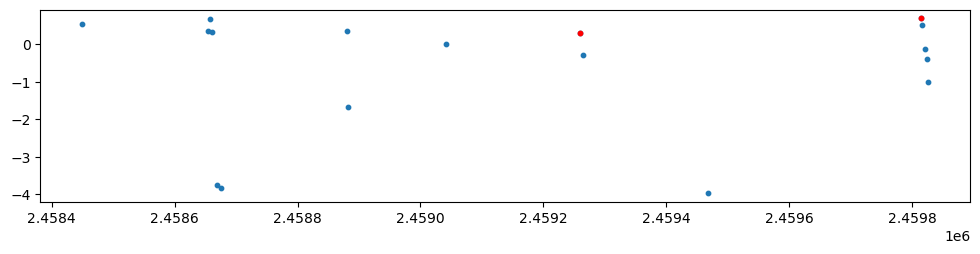

0.005206919232020931
0.15387543761534028


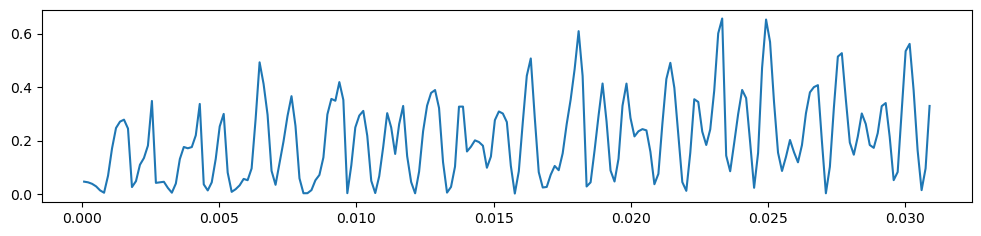

2 0.6689501025121938 0.0003570804365264384 4.655865884995446 1.968215469703912
ZTF21abhrevv UGSU


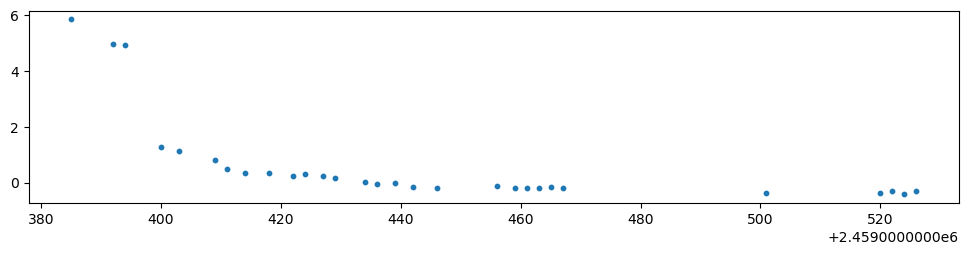

error


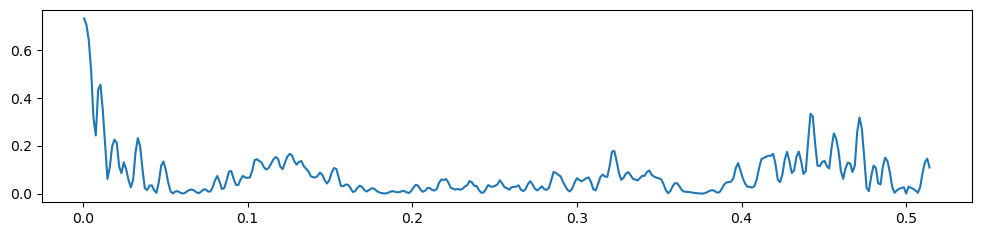

zero-size array to reduction operation maximum which has no identity
ZTF18abavrji UGER


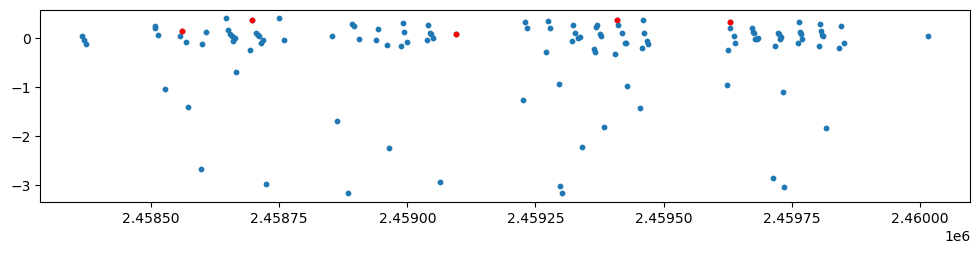

0.2568112366118349
0.04050166242416641


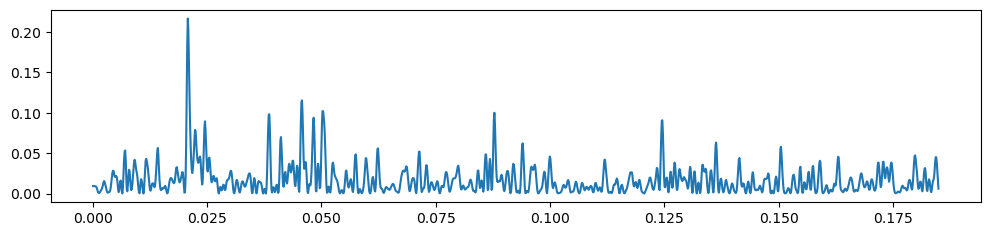

5 0.9055082785466557 2.1587353635170374e-05 3.5796137088026576 1.782073146663322
ZTF18aanwrti UGER


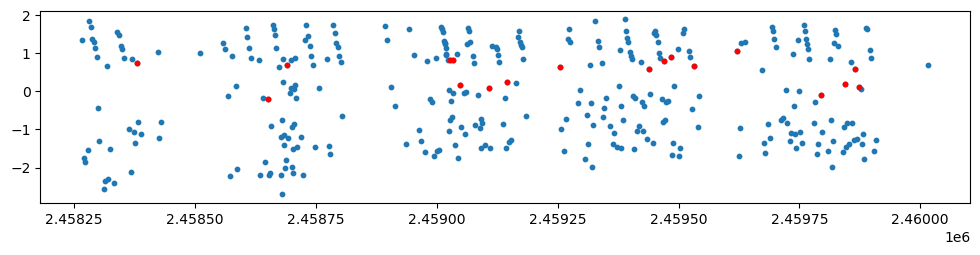

0.7941643172430979
0.8270118165557143


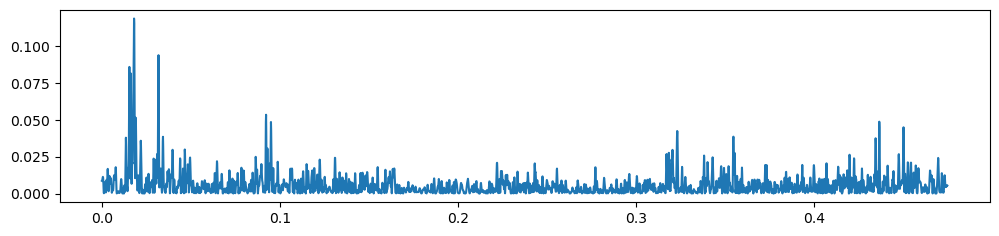

18 0.7369882659095341 4.76888970658144e-05 4.597020379059769 1.9964408964496059
ZTF18aammncw UGER


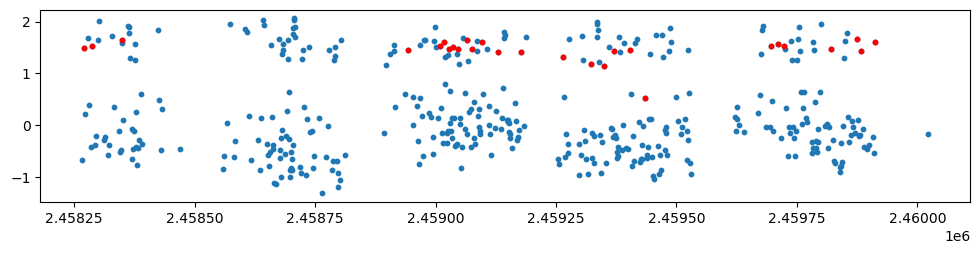

1.8039060505580728
0.47766439828705654


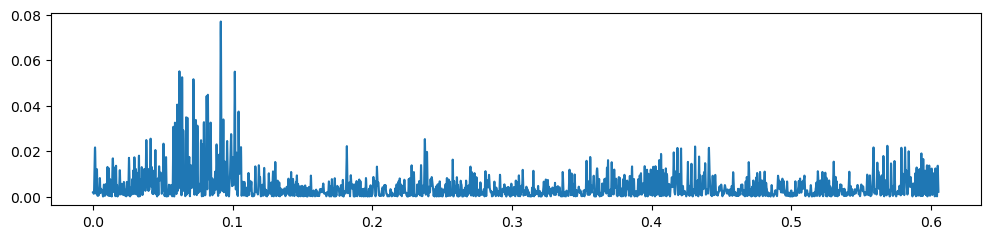

27 0.3763470176238546 -8.446691360670613e-05 3.377169457887735 1.9897589798434225
ZTF19abzzuin UG/IBWD


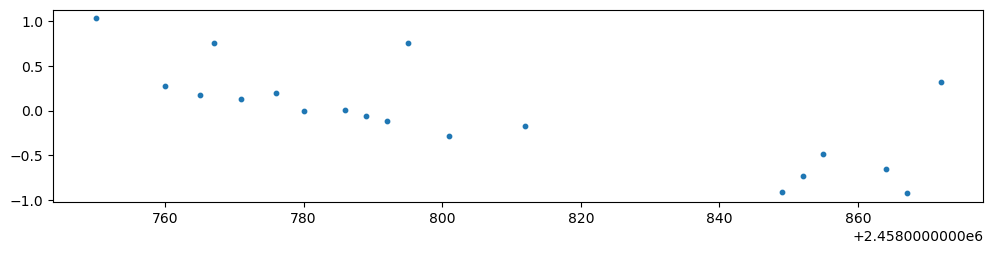

error


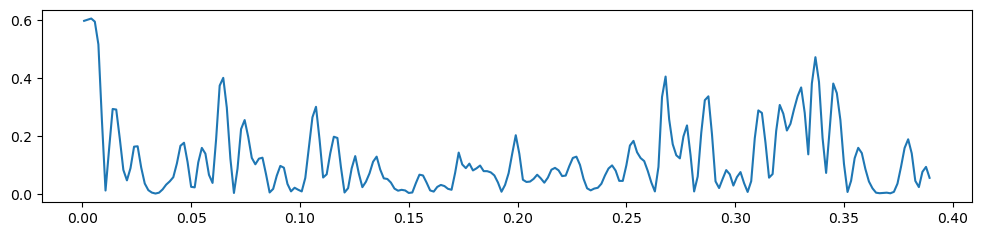

zero-size array to reduction operation maximum which has no identity
ZTF18acyerom UG/IBWD


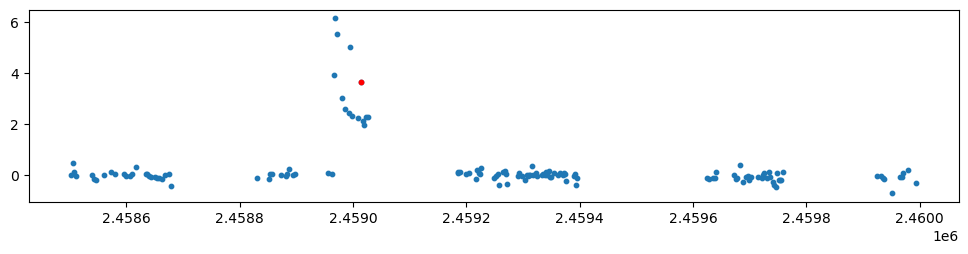

0.28650909222622756
0.0015288638859457181


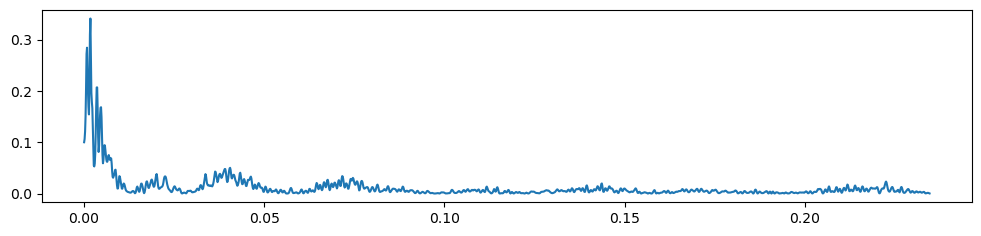

1 0.013709667554014747 -0.0005331143230877173 6.845547415570028 1.432545461131138
ZTF20abgbxco UGSU/IBWD


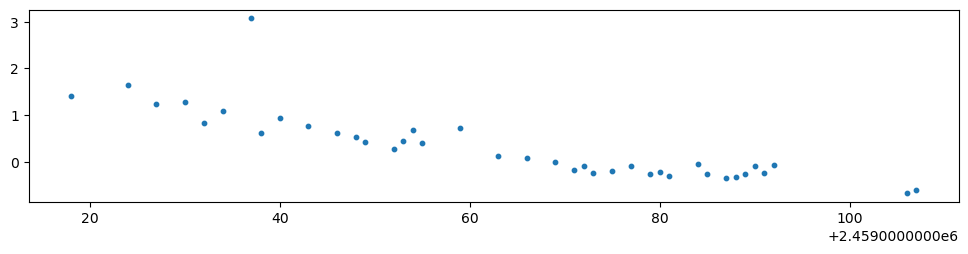

error


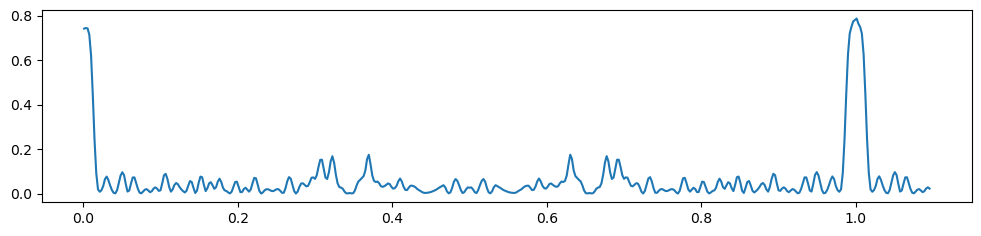

zero-size array to reduction operation maximum which has no identity
ZTF18achemir UGZ


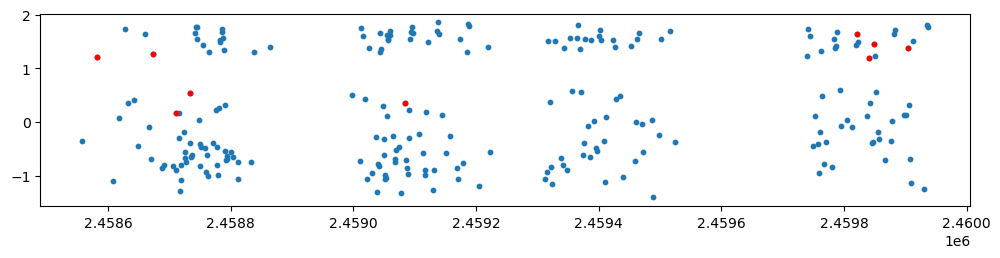

1.0680549686776146
0.6014185587365404


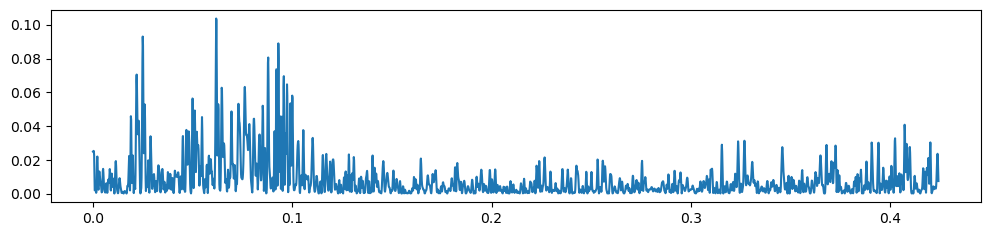

9 0.01624112780923936 0.0004059636698704483 3.264144598860959 1.959069950444622
ZTF18abmaqoi UGZ


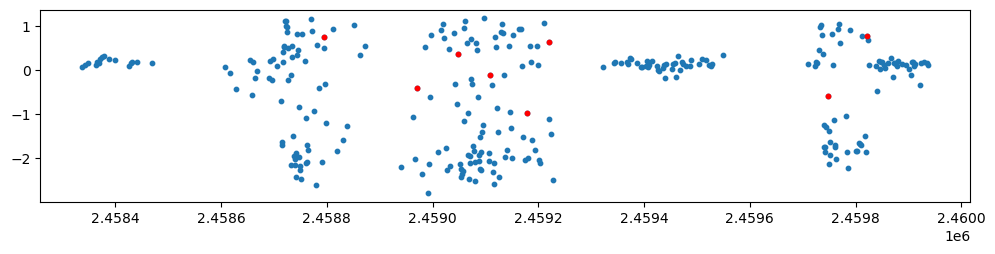

1.7361708811918746
0.6398114054808755


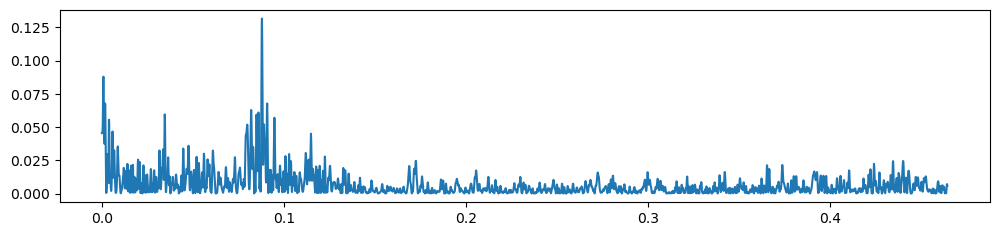

8 0.3274333757133916 0.00014286836871247327 3.9683449112311564 1.952460492940613
ZTF18adlkmio UGZ


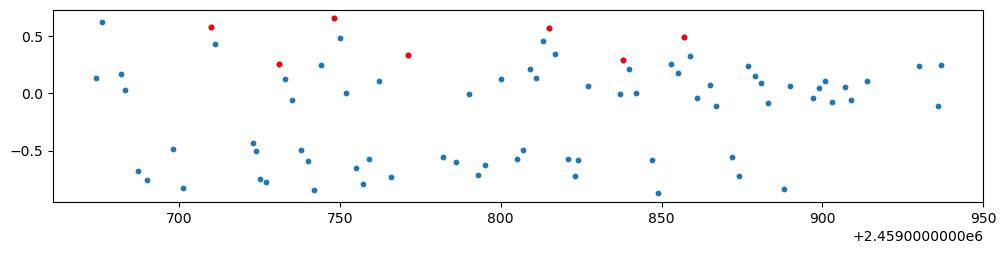

0.2572302006095546
0.09353825476711077


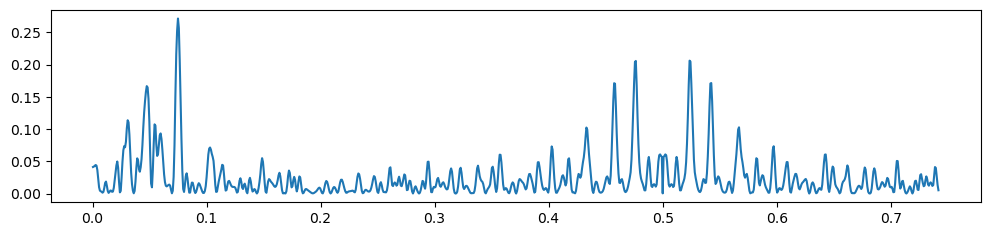

7 0.16932625061089135 0.0009480561421095919 1.5238741349302494 1.4943518381051888
ZTF18abiwtyk UGZ


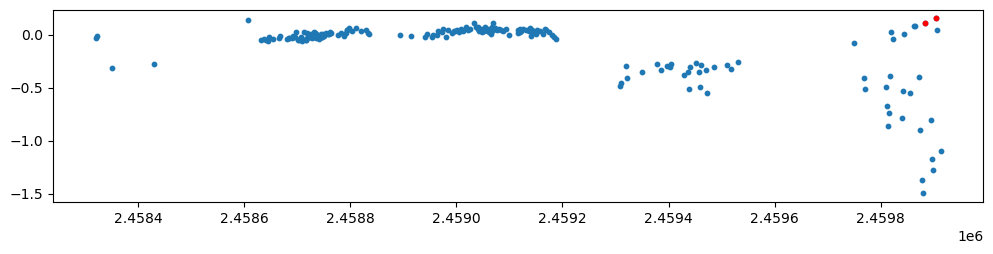

0.347299922062585
0.12535450626477349


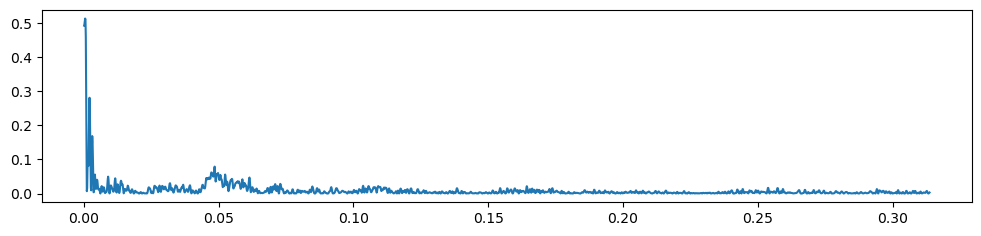

2 1.89941114004615e-22 -0.000436026810703564 1.6507432525517096 1.38919968825034
ZTF18aaueblh UGZ


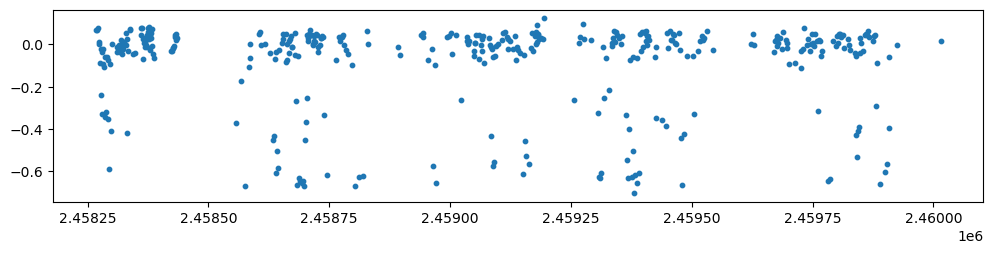

error


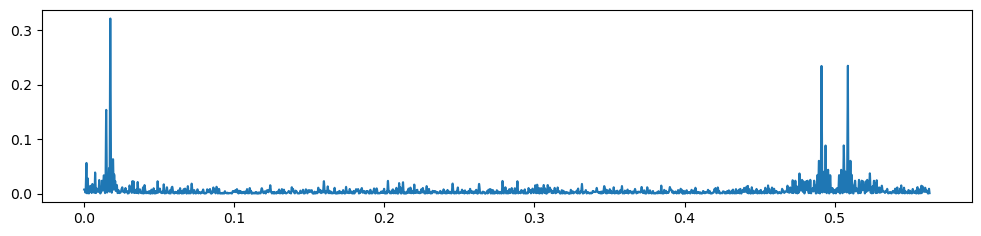

ZTF18aakvuwy UGZ


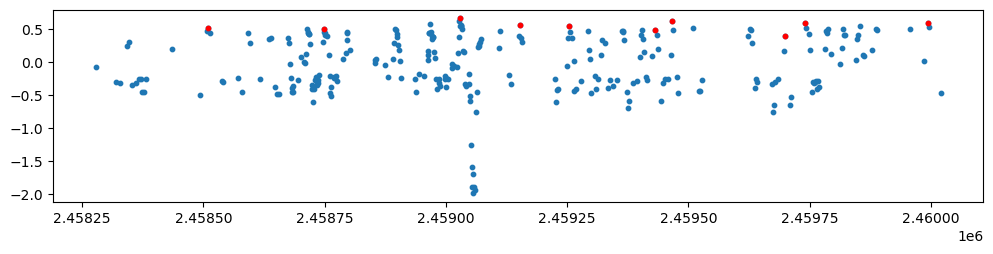

0.06012417053984375
0.10517043126506528


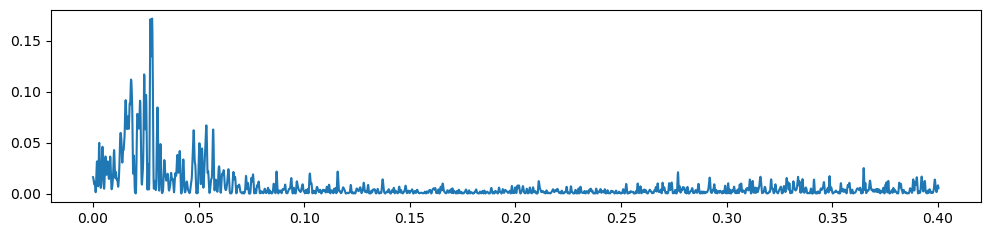

10 0.09063586182463199 0.00011139051153886592 2.6575524095314798 1.377286663661259


In [72]:
from scipy.signal import find_peaks
from scipy.stats import linregress

# objlist = ['ZTF18aanwrti','ZTF18abmaqoi','ZTF18aabfcyi','ZTF18aakvuwy','ZTF18abajshu','ZTF20abgbxco','ZTF21abhrevv',
#            'ZTF18aagrgoe','ZTF18abchhxd']

for obj in objlist:
    type = df_ZTF_CVs[df_ZTF_CVs['Xmatch_obj']==obj]['Type'].iloc[0]
    print(obj, type)

    # Load and process lasair light curve
    lc_test = load_lasair_lc(oid=obj, path=f'../lightcurves_dataset/lasair_{date}')
    lc_appmag_test = lasair_clean(lc_test, limit=25, magerrlim=1)

    # Create a copy of the light curve
    lc = lc_appmag_test.copy()

    # subtract median magnitude from each filter and multiply by -1 to flip the light curve
    lc.loc[lc['fid']==1, 'dc_mag'] = (lc.loc[lc['fid']==1, 'dc_mag'] - lc.loc[lc['fid']==1, 'dc_mag'].median())*(-1)
    lc.loc[lc['fid']==2, 'dc_mag'] = (lc.loc[lc['fid']==2, 'dc_mag'] - lc.loc[lc['fid']==2, 'dc_mag'].median())*(-1)
    # Convert jd to ingeter
    lc['jd'] = lc['jd'].astype(int)
    # for a given filter, if the same jd is repeated, keep the first one
    lc = lc.drop_duplicates(subset=['jd', 'fid'], keep='first')

    # Display light curve
    display_lightcurve(lc,x='jd',y='dc_mag',errorCol=errCollasair2, autorange=True)

    # Split light curve into g and r filters
    lc_g = lc[lc['fid']==1]
    lc_r = lc[lc['fid']==2]

    # Method for finding standstills in Z_Cam light curves
    def standstill_finder(lc, pnt_threshold=20, window_size=10):
    # Rolling standard deviation for light curves with equal or more than 20 data points
        if len(lc) >= pnt_threshold:
            # Rolling standard deviation for window size 10
            roll_std = lc['dc_mag'].rolling(window_size).std()
            # Rolling mean for window size 10
            roll_mean = lc['dc_mag'].rolling(window_size).mean()
            # Maximum and minimum of light curve
            lc_max = lc['dc_mag'].max()
            lc_min = lc['dc_mag'].min()
            # index of minimum of rolling standard deviation
            min_roll_std = roll_std.idxmin()
            # mean of the window with the minimum rolling standard deviation
            min_roll_std_mean = roll_mean[min_roll_std]
            # fraction of the maximum light curve amplitude that min_roll_std_mean is, i.e., location relative to the maximum of the standstill.
            standstill_level = (min_roll_std_mean-lc_min)/(lc_max-lc_min)

            print(f'Rolling std max: {roll_std.max()}',
                f'\nRolling std min: {roll_std.min()}',
                f'\nRatio of max and min of rolling std: {roll_std.max()/roll_std.min()}',
                f'\nMean brightness of window with minimum rolling std: {min_roll_std_mean}'
                f'\nStandstill level: {standstill_level}')
            
            return roll_std.max(), roll_std.min(), roll_std.max()/roll_std.min(), min_roll_std_mean, standstill_level
        else:
            return None
        

    # Find peaks in the light curve
    peaks, properties = find_peaks(lc_g['dc_mag'], 
                                height=None, 
                                threshold=None, 
                                distance=None, 
                                prominence=(1,2), 
                                width=None, 
                                wlen=None ,
                                rel_height=0.5, 
                                plateau_size=None)


    # Plot the location of identified peaks
    import numpy as np
    import matplotlib.pyplot as plt 
    plt.figure(figsize=(12,2.5))
    plt.scatter(lc_g['jd'], lc_g['dc_mag'],s=10)
    plt.scatter(lc_g.iloc[peaks]['jd'], lc_g.iloc[peaks]['dc_mag'], s=10,c='r')
    plt.show()

    try:
        # Get the times of the peaks and the times of the left and right edges of the peaks
        peak_times = lc_g.iloc[peaks]['jd'].values
        times_left_bases = lc_g.iloc[properties['left_bases']]['jd'].values
        times_right_bases = lc_g.iloc[properties['right_bases']]['jd'].values
        # print(properties['prominences'])
        # print(properties['prominences']/(peak_times-times_left_bases))
        print(np.max(properties['prominences']/(peak_times-times_left_bases)))
        print(np.max(properties['prominences']/(times_right_bases-peak_times)))
    except:
        print('error')


    try:
        # Plot the lomb scargle periodogram
        from astropy.timeseries import LombScargle
        frequency, power = LombScargle(lc_g['jd'], lc_g['dc_mag']).autopower()
        plt.figure(figsize=(12,2.5))
        plt.plot(frequency, power)
        plt.show()
    except:
        print('error')


    # display row 33 of lc_g with just the 'dc_mag' column
    try:
        if len(peaks)==0:
            if (linregress(lc_g['jd'], lc_g['dc_mag']).pvalue < 0.05):
                print(len(peaks), 1,
                    linregress(lc_g['jd'], lc_g['dc_mag']).pvalue,
                    linregress(lc_g['jd'], lc_g['dc_mag']).slope,
                    lc_g['dc_mag'].max()-lc_g['dc_mag'].min(),
                    properties['prominences'].max())
        else:
            print(len(peaks),
                    linregress(lc_g['jd'], lc_g['dc_mag']).pvalue,
                    linregress(lc_g['jd'], lc_g['dc_mag']).slope,
                    lc_g['dc_mag'].max()-lc_g['dc_mag'].min(),
                    properties['prominences'].max())
            
    except Exception as e:
        print(e)

In [ ]:
# plot the lomb-scargle periodogram of the light curve
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
import numpy as np
